<a href="https://colab.research.google.com/github/jimitogni/dissertacao/blob/master/v1_covid19_multiple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Head

In [0]:
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
from fastai.vision import *
from fastai.widgets import ClassConfusion
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications import MobileNet, InceptionResNetV2, DenseNet201, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline

Using TensorFlow backend.


In [0]:
#criando o nosso top layer
def addTopModel(bottom_model, num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dropout(0,5)(top_model)
  top_model = Dense(num_classes, activation='softmax')(top_model)

  return top_model

#Datasets

In [0]:
%%shell

export KAGGLE_USERNAME=jimitogni
export KAGGLE_KEY=aea778a52ae308a26e4ad5dad779ada9

kaggle datasets download paultimothymooney/chest-xray-pneumonia
unzip '/content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip' -d '/content/drive/My Drive/UNICAMP/databases/covid19/'

cd '/content/drive/My Drive/UNICAMP/databases/covid19/'
git clone https://github.com/ieee8023/covid-chestxray-dataset.git

100% 2.29G/2.29G [00:29<00:00, 31.1MB/s]
100% 2.29G/2.29G [00:29<00:00, 83.1MB/s]
'chest-xray-pneumonia.zip' -> '/content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip'
cp: '/content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip': can make relative symbolic links only in current directory
unzip:  cannot find or open /content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip, /content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip.zip or /content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip.ZIP.
Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 1616, done.
remote: Total 1616 (delta 0), reused 0 (delta 0), pack-reused 1616
Receiving objects: 100% (1616/1616), 219.51 MiB | 14.64 MiB/s, done.
Resolving deltas: 100% (774/774), done.
Checking out files: 100% (350/350), done.


In [0]:
!unzip '/content/drive/My Drive/UNICAMP/databases/covid19/chest-xray-pneumonia.zip' -d '/content/drive/My Drive/UNICAMP/databases/covid19/'

In [0]:
# Load Kaggle Pneumonia Dataset
def get_dataset(path, label):
  return [[path+x, label] for x in os.listdir(path) if not x.startswith('.')]

In [0]:
def split_dataset():
  #path_drive = '/content/drive/My Drive/UNICAMP/databases/covid19/'
  root = '/content/drive/My Drive/UNICAMP/databases/covid19/chest_xray/train/'
  normal_xray = get_dataset(root+'NORMAL/', 'normal')
  pneumonia_xray = get_dataset(root+'PNEUMONIA/', 'pneumonia')
  #print(len(normal_xray), normal_xray[0:5])
  #print(len(pneumonia_xray), pneumonia_xray[0:5])

  # Load Covid-19 Dataset
  metadata_path='/content/drive/My Drive/UNICAMP/databases/covid19/covid-chestxray-dataset/metadata.csv'
  srcpath = '/content/drive/My Drive/UNICAMP/databases/covid19/covid-chestxray-dataset/images/'
  df=pd.read_csv(metadata_path)
  covid_patients=df['finding']=='COVID-19'
  PA=df['view']=='PA'
  PA_covid=df[covid_patients & PA]
  covid_xray = [[srcpath + files, 'covid'] for files in PA_covid['filename']]
  #print(len(covid_xray), covid_xray[0:5])

  random.shuffle(normal_xray)
  random.shuffle(pneumonia_xray)
  random.shuffle(covid_xray)

  # gerando dados balanceados e randomizados
  print("min_size = {}".format(min(len(normal_xray), len(pneumonia_xray), len(covid_xray))-1))
  min_size = min(len(normal_xray), len(pneumonia_xray), len(covid_xray))-1
  dataset = normal_xray[0:min_size] + covid_xray[0:min_size] + pneumonia_xray[0:min_size]
  random.shuffle(dataset)

  #print(len(dataset), dataset[0:5])

  # carregando os dados para um df pandas
  df = pd.DataFrame(dataset, columns=['X', 'y']).sample(frac=1)
  #print(df)

  X = df['X']
  y = df['y']

  classes= y.unique()
  print("Classes: {}".format(classes))

  # Split em train, val, e test
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1) #pega % do treino e separa para teste
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) #pega % do treino e separa para teste

  print("-----"*10)
  print("Total de imagens= {}, \nDados para: treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(X_train), len(X_val), len(X_test)))
  print("-----"*10)
  print("Total Y= {}, \nDados para: Treino= {}, \nValidação= {} \nTeste= {} ".format(len(df), len(y_train), len(y_val), len(y_test)))

  #!rm -rf dataset/ #remove a pasta se ela ja existir

  #cria uma nova pasta com as duas bases de dados agrupadas
  for dtype, dinputs, doutputs in [['train', X_train, y_train], ['val', X_val, y_val], ['test', X_test, y_test]]:
    for _X, _y in zip(dinputs, doutputs):
      path = '/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/'+dtype+'/'+_y
      os.makedirs(path, exist_ok=True)
      print(_X, path)
      shutil.copy(_X, path)

  #!tar -czf dataset.tar.gz dataset/ #guarda toda a base obtida em um arquivo zip


In [0]:
split_dataset()

In [0]:
# Path to data
data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir + 'normal/'
pneumonia_cases_dir = train_dir + 'pneumonia/'
covid_cases_dir = train_dir + 'covid/'

print("Datasets:",os.listdir(data_dir))
print("Train:\t", os.listdir(train_dir))
print("Test:\t", os.listdir(test_dir))

Datasets: ['train', 'val', 'test']
Train:	 ['covid', 'pneumonia', 'normal']
Test:	 ['normal', 'pneumonia', 'covid']


In [0]:
#
num_classes = 3
img_rows, img_cols = 500, 500

train_data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/train'
validation_data_dir = '/content/drive/My Drive/UNICAMP/databases/covid19/dataset_final/val'

nb_train_samples = 237
nb_validation_samples = 80

epochs = 100
batch_size = 16

In [0]:
#data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

#nao faz data aug
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_rows, img_cols),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size=(img_rows, img_cols),
                                                              batch_size=batch_size,
                                                              class_mode='categorical')


Found 453 images belonging to 3 classes.
Found 143 images belonging to 3 classes.


#Visualizando algumas amostras dos datasets

In [0]:
### VERIFICAR SE AS CLASSES ESTÃO CORRETAS

# Get the list of all the images
normal_cases = glob(normal_cases_dir+'/*.jpeg')
pneumonia_cases = glob(pneumonia_cases_dir+'/*.jpeg')
covid_cases = glob(covid_cases_dir+'/*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Go through all the covid cases. The label for these cases will be 2
for img in covid_cases:
    train_data.append((img, 2))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()
covid_samples = (train_data[train_data['label']==2]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples + covid_samples
del pneumonia_samples, normal_samples, covid_samples

# Plot the data 
f, ax = plt.subplots(3,5, figsize=(30,15))
for i in range(15):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    elif i>=5 and i<10:
        ax[i//5, i%5].set_title("Normal")
    else:
        ax[i//5, i%5].set_title("Covid")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

#Modelos

##ResNet50v2

234553344/234545216 [==============================] - 5s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:680: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/100
14/14 [==============================] - 155s 11s/step - loss: 0.9816 - accuracy: 0.5305 - val_loss: 0.6557 - val_accuracy: 0.7750

Epoch 00001: val_loss improved from inf to 0.65565, saving model to ResNet152V2.h5
Epoch 2/100
14/14 [==============================] - 148s 11s/step - loss: 0.4608 - accuracy: 0.8438 - val_loss: 0.8951 - val_accuracy: 0.5190

Epoch 00002: val_loss did not improve from 0.65565
Epoch 3/100
14/14 [==============================] - 25s 2s/step - loss: 0.4292 - accuracy: 0.8214 - val_loss: 1.4591 - val_accuracy: 0.4375

Epoch 00003: val_loss did not improve from 0.65565
Epoch 4/100
14/14 [==============================] - 18s 1s/step - loss: 0.3184 - accuracy: 0.8873 - val_loss: 1.6370 - val_accuracy: 0.4051

Epoch 00004: val_loss did not improve from 0.65565
Epoch 5/100
14/14 [==============================] - 21s 1s/step - loss: 0.2917 - accuracy: 0.9107 - val_loss: 0.7285 - val_accuracy: 0.5250

Epoch 00005: val_loss did not improve from 0.65565

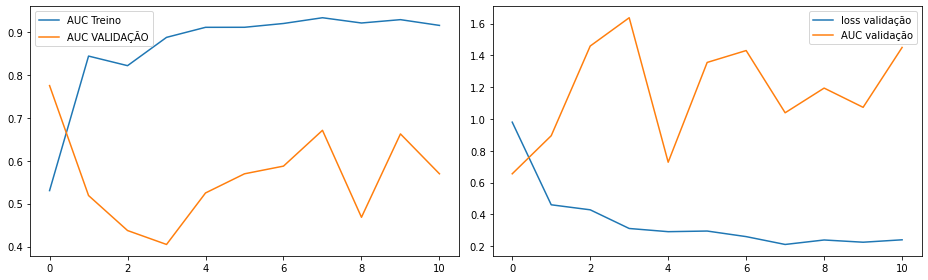

In [0]:
#ResNet152V2

ResNet152V2 = ResNet152V2(include_top=False, weights='imagenet', input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido, 1pb

for layer in ResNet152V2.layers:
  layer.trainable=False


FC = addTopModel(ResNet152V2, num_classes) #MobileNet = bottom_model
model = Model(input=ResNet152V2.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint('ResNet152V2.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001), #rmsprop
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

# print()
# print("Com os valores:")
# print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##InceptionResNetv2

219062272/219055592 [==============================] - 5s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 249, 249, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 249, 249, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 249, 249, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:680: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/100
14/14 [==============================] - 31s 2s/step - loss: 1.2701 - accuracy: 0.3568 - val_loss: 1.0212 - val_accuracy: 0.3625

Epoch 00001: val_loss improved from inf to 1.02118, saving model to InceptionResNetV2.h5
Epoch 2/100
14/14 [==============================] - 13s 933ms/step - loss: 1.0156 - accuracy: 0.4777 - val_loss: 0.8970 - val_accuracy: 0.5063

Epoch 00002: val_loss improved from 1.02118 to 0.89700, saving model to InceptionResNetV2.h5
Epoch 3/100
14/14 [==============================] - 19s 1s/step - loss: 0.9386 - accuracy: 0.5804 - val_loss: 0.7939 - val_accuracy: 0.7625

Epoch 00003: val_loss improved from 0.89700 to 0.79391, saving model to InceptionResNetV2.h5
Epoch 4/100
14/14 [==============================] - 17s 1s/step - loss: 0.5985 - accuracy: 0.7606 - val_loss: 1.1904 - val_accuracy: 0.6329

Epoch 00004: val_loss did not improve from 0.79391
Epoch 5/100
14/14 [==============================] - 19s 1s/step - loss: 0.5490 - accuracy: 0.7418 - va

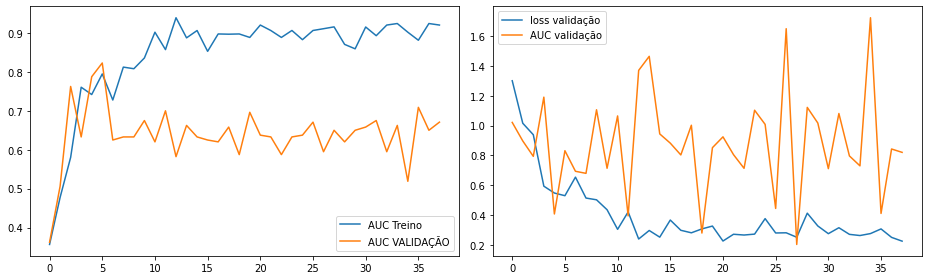



Com os valores:
batch size: 16 - Epocas: 100


In [0]:
#InceptionResNetV2
InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in InceptionResNetV2.layers:
  layer.trainable=False

FC = addTopModel(InceptionResNetV2, num_classes) #MobileNet = bottom_model
model = Model(input=InceptionResNetV2.input, output=FC) #bottom layers, top layer

model.summary()

checkpoint = ModelCheckpoint('InceptionResNetV2.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##Inceptionv3

87916544/87910968 [==============================] - 3s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:680: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 249, 249, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 249, 249, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 249, 249, 32) 0           batch_normalization_204[0][0]    
____________________________________________________________________________________________

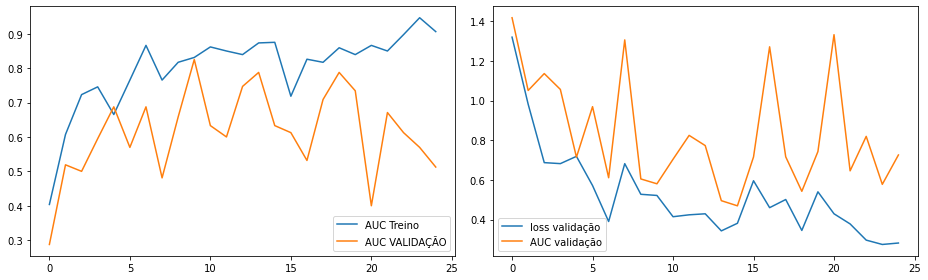



Com os valores:
batch size: 16 - Epocas: 100


In [0]:
#Inception2
InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in InceptionV3.layers:
  layer.trainable=False

FC = addTopModel(InceptionV3, num_classes) #MobileNet = bottom_model
model = Model(input=InceptionV3.input, output=FC) #bottom layers, top layer

model.summary()

checkpoint = ModelCheckpoint('InceptionV3.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##DenseNet201

74842112/74836368 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 500, 500, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 506, 506, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 250, 250, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 250, 250, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:680: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/100
14/14 [==============================] - 34s 2s/step - loss: 1.2847 - accuracy: 0.4930 - val_loss: 0.8316 - val_accuracy: 0.6500

Epoch 00001: val_loss improved from inf to 0.83164, saving model to DenseNet201.h5
Epoch 2/100
14/14 [==============================] - 14s 979ms/step - loss: 0.6873 - accuracy: 0.6830 - val_loss: 1.0872 - val_accuracy: 0.4051

Epoch 00002: val_loss did not improve from 0.83164
Epoch 3/100
14/14 [==============================] - 19s 1s/step - loss: 0.8584 - accuracy: 0.6244 - val_loss: 0.7295 - val_accuracy: 0.6250

Epoch 00003: val_loss improved from 0.83164 to 0.72953, saving model to DenseNet201.h5
Epoch 4/100
14/14 [==============================] - 17s 1s/step - loss: 0.4706 - accuracy: 0.8571 - val_loss: 0.8523 - val_accuracy: 0.6962

Epoch 00004: val_loss did not improve from 0.72953
Epoch 5/100
14/14 [==============================] - 18s 1s/step - loss: 0.5126 - accuracy: 0.8216 - val_loss: 0.5571 - val_accuracy: 0.8250

Epoch 00005: va

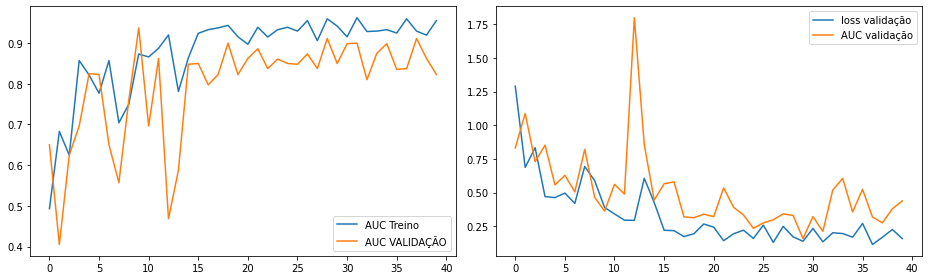



Com os valores:
batch size: 16 - Epocas: 100


In [0]:
#DenseNet201
DenseNet201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in DenseNet201.layers:
  layer.trainable=False

FC = addTopModel(DenseNet201, num_classes) #MobileNet = bottom_model
model = Model(input=DenseNet201.input, output=FC) #bottom layers, top layer

model.summary()

checkpoint = ModelCheckpoint('DenseNet201.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##VGG19

80142336/80134624 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:680: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/100
14/14 [==============================] - 20s 1s/step - loss: 1.1605 - accuracy: 0.4152 - val_loss: 1.0953 - val_accuracy: 0.2750

Epoch 00001: val_loss improved from inf to 1.09534, saving model to VGG19.h5
Epoch 2/100
14/14 [==============================] - 16s 1s/step - loss: 0.9983 - accuracy: 0.5869 - val_loss: 1.0865 - val_accuracy: 0.5443

Epoch 00002: val_loss improved from 1.09534 to 1.08653, saving model to VGG19.h5
Epoch 3/100
14/14 [==============================] - 17s 1s/step - loss: 0.8269 - accuracy: 0.5938 - val_loss: 0.7297 - val_accuracy: 0.4500

Epoch 00003: val_loss improved from 1.08653 to 0.72972, saving model to VGG19.h5
Epoch 4/100
14/14 [==============================] - 16s 1s/step - loss: 0.9037 - accuracy: 0.5258 - val_loss: 1.0184 - val_accuracy: 0.5316

Epoch 00004: val_loss did not improve from 0.72972
Epoch 5/100
14/14 [==============================] - 17s 1s/step - loss: 0.7485 - accuracy: 0.6432 - val_loss: 0.6972 - val_accuracy: 0.6125



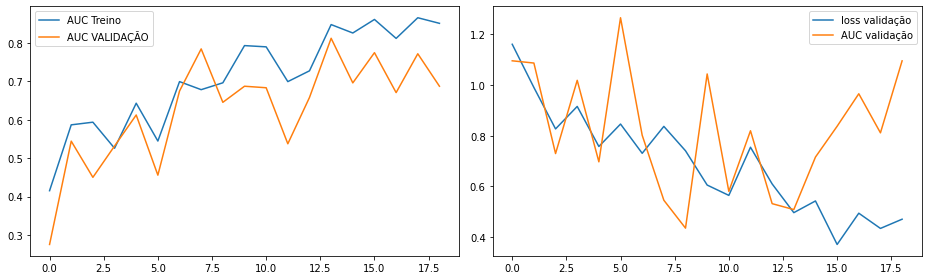



Com os valores:
batch size: 16 - Epocas: 100


In [0]:
#VGG19
VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in VGG19.layers:
  layer.trainable=False

FC = addTopModel(VGG19, num_classes) #MobileNet = bottom_model
model = Model(input=VGG19.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint('VGG19.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##MobileNet

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:680: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/100
14/14 [==============================] - 21s 2s/step - loss: 1.1597 - accuracy: 0.4598 - val_loss: 1.0396 - val_accuracy: 0.4875

Epoch 00001: val_loss improved from inf to 1.03963, saving model to MobileNetV2.h5
Epoch 2/100
14/14 [==============================] - 14s 1s/step - loss: 0.6370 - accuracy: 0.7277 - val_loss: 2.4286 - val_accuracy: 0.3291

Epoch 00002: val_loss did not improve from 1.03963
Epoch 3/100
14/14 [==============================] - 16s 1s/step - loss: 0.5714 - accuracy: 0.7700 - val_loss: 1.8246 - val_accuracy: 0.5250

Epoch 00003: val_loss did not improve from 1.03963
Epoch 4/100
14/14 [==============================] - 17s 1s/step - loss: 0.4814 - accuracy: 0.7991 - val_loss: 2.1038 - val_accuracy: 0.4937

Epoch 00004: val_loss did not improve from 1.03963
Epoch 5/100
14/14 [==============================] - 17s 1s/step - loss: 0.4501 - accuracy: 0.8438 - val_loss: 0.8582 - val_accuracy: 0.4750

Epoch 00005: val_loss improved from 1.03963 to 0.85822

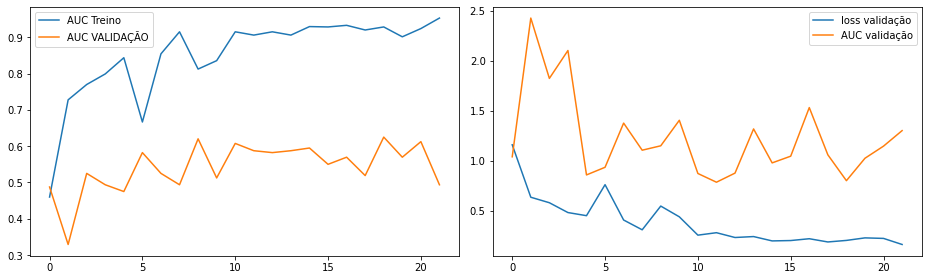



Com os valores:
batch size: 16 - Epocas: 100


In [0]:
#MobileNetV2
MobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in MobileNetV2.layers:
  layer.trainable=False

FC = addTopModel(MobileNetV2, num_classes) #MobileNet = bottom_model
model = Model(input=MobileNetV2.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint('MobileNetV2.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

##NASnet

In [0]:
#NASNetLarge
NASNetLarge = NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in NASNetLarge.layers:
  layer.trainable=False

FC = addTopModel(NASNetLarge, num_classes) #MobileNet = bottom_model
model = Model(input=NASNetLarge.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint('NASNetLarge.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

ValueError: ignored

##Xcepiton

83689472/83683744 [==============================] - 2s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:680: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/100
14/14 [==============================] - 23s 2s/step - loss: 1.0380 - accuracy: 0.5848 - val_loss: 0.8504 - val_accuracy: 0.7750

Epoch 00001: val_loss improved from inf to 0.85043, saving model to Xception.h5
Epoch 2/100
14/14 [==============================] - 16s 1s/step - loss: 0.6501 - accuracy: 0.7418 - val_loss: 1.1755 - val_accuracy: 0.4304

Epoch 00002: val_loss did not improve from 0.85043
Epoch 3/100
14/14 [==============================] - 19s 1s/step - loss: 0.5484 - accuracy: 0.7589 - val_loss: 1.6423 - val_accuracy: 0.3875

Epoch 00003: val_loss did not improve from 0.85043
Epoch 4/100
14/14 [==============================] - 17s 1s/step - loss: 0.6178 - accuracy: 0.7746 - val_loss: 1.6235 - val_accuracy: 0.3797

Epoch 00004: val_loss did not improve from 0.85043
Epoch 5/100
14/14 [==============================] - 17s 1s/step - loss: 0.5996 - accuracy: 0.7793 - val_loss: 1.5166 - val_accuracy: 0.3375

Epoch 00005: val_loss did not improve from 0.85043
Epoch 

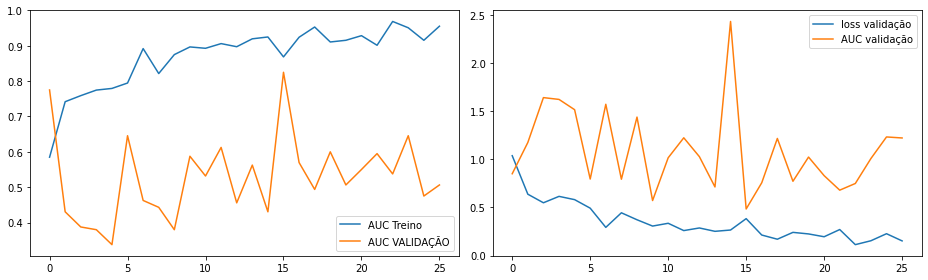



Com os valores:
batch size: 16 - Epocas: 100


In [0]:
#Xception
Xception = Xception(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) #largura, altura, 3=RGB colorido

for layer in Xception.layers:
  layer.trainable=False

FC = addTopModel(Xception, num_classes) #MobileNet = bottom_model
model = Model(input=Xception.input, output=FC) #bottom layers, top layer

#model.summary()

checkpoint = ModelCheckpoint('Xception.h5',
                             monitor='val_loss',
                             mode=min,
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0001)

callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=nb_train_samples//batch_size,
                              epochs=epochs,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=nb_validation_samples//batch_size)


print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))

#Resultados

In [0]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

print()
# Evaluate the model
#scores = history.history.evaluate_generator(test_generator)
#print("\n%s: %.2f%%" % (history.metrics_names[1], scores[1]*100))

print()
print("Com os valores:")
print("batch size: {} - Epocas: {}".format(batch_size, epochs))